In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
# read in all words
# words = open('/content/drive/MyDrive/names.txt', 'r').read().splitlines()
# dataF = pd.read_csv('/content/Indian_Names.csv').astype(str)
# words = dataF['Name'].tolist()
data = pd.read_csv('/content/Indian-Male-Names.csv')
# words = data['name'].astype(str)
data.head

<bound method NDFrame.head of                       name gender    race
0                  barjraj      m  indian
1             ramdin verma      m  indian
2          sharat chandran      m  indian
3          birender mandal      m  indian
4                     amit      m  indian
...                    ...    ...     ...
14840               buddha      m  indian
14841               mukesh      m  indian
14842                 monu      m  indian
14843  govind prasad shahu      m  indian
14844               deepak      m  indian

[14845 rows x 3 columns]>

In [ ]:
import re
words = []
for text in data['name'].astype(str):
  text = re.sub(r'[^a-z]',' ', text)
  text = re.sub(r'[[]]',' ', text)
  text = text.lower()
  words.append(text)
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

14845
42
['barjraj', 'ramdinverma', 'sharatchandran', 'birendermandal', 'amit', 'kushal', 'kasid', 'shivprakash']


In [ ]:
# build vocab of chararcters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
28


In [ ]:
#shuffle up the words
import random
random.seed(42)
random.shuffle(words)



In [ ]:
#build the dataset

block_size = 8 # context length : How many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [] , []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] #crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape , Y.shape)
  return X , Y


n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev , Ydev = build_dataset(words[n1:n2])
Xte , Yte = build_dataset(words[n2:])

torch.Size([130764, 8]) torch.Size([130764])
torch.Size([16359, 8]) torch.Size([16359])
torch.Size([16473, 8]) torch.Size([16473])


In [ ]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> s
.......s ---> h
......sh ---> e
.....she ---> r
....sher ---> h
...sherh ---> a
..sherha ---> s
.sherhas ---> a
sherhasa ---> n
herhasan ---> .
........ ---> g
.......g ---> a
......ga ---> u
.....gau ---> r
....gaur ---> a
...gaura ---> v
..gaurav ---> .
........ ---> r
.......r ---> o
......ro ---> h


In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
#----------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]
#-----------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
#------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

#------------------------------------------------------------------

class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []
#-------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]
#---------------------------------------------------------------------


In [ ]:
torch.manual_seed(42);

In [ ]:
n_embd = 16 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])
# parameters init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters =  model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True



83015


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # with torch.no_grad():
  #   ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
  if i == 9999:
    break

      0/ 200000: 2.0781
   1000/ 200000: 1.8878
   2000/ 200000: 1.7624
   3000/ 200000: 1.4659
   4000/ 200000: 1.6790


IndexError: ignored

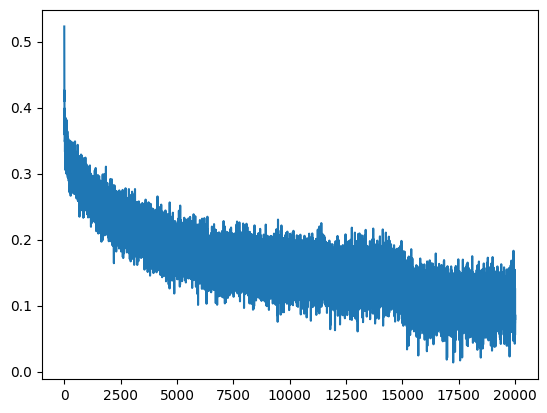

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [ ]:
# put layers into eval mode [needed for batchmore especially]
for layer in model.layers:
  layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.2254469394683838
val 2.5194010734558105


In [ ]:
# sample from the model


for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...


    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

charangef.
madhuni.
sangit.
safiq.
garib.
krish.
chokan.
partap.
narayana.
chitrangan.
nohiras.
soniya.
palaram.
pooran.
bhojpal.
farkoa.
rajampal.
gahpat.
adnan.
mem.


In [ ]:
ix = torch.randint(0, Xtr.shape[0], (4, ))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb



torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  1,  2, 18,  9],
        [ 0,  0,  0, 22,  9,  3, 20, 15],
        [ 0,  0,  1, 14,  7,  5, 12,  5],
        [19, 15,  3,  8,  9, 11,  1,  9]])

In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [ ]:
model.layers[0].out.shape  #output of embedding

torch.Size([4, 8, 10])

In [ ]:
model.layers[1].out.shape #output of flatten

torch.Size([4, 80])

In [ ]:
model.layers[2].out.shape #output of linear

torch.Size([4, 200])

In [ ]:
e = torch.randn(4, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10-d vec get connected
e.view()

RuntimeError: ignored

In [ ]:
import pandas as pd
dataF = pd.read_csv('/content/Indian_Names.csv')
word = dataF['Name'].tolist()
word[:8]

['aabid', 'aabida', 'aachal', 'aadesh', 'aadil', 'aadish', 'aaditya', 'aaenab']